In [1]:
from asap.util.io import read_config
from collections import namedtuple
from pathlib import Path
import pandas as pd
import numpy as np
from asap.data.dataloader import DataSet
from asap.util import topics
from asap.annotation import ASAPNMF
import asapc
import matplotlib.pylab as plt
import seaborn as sns
import colorcet as cc
from sklearn.preprocessing import StandardScaler
# import logging


experiment = '/projects/experiments/asapp/'
server = Path.home().as_posix()
experiment_home = server+experiment
experiment_config = read_config(experiment_home+'config.yaml')
args = namedtuple('Struct',experiment_config.keys())(*experiment_config.values())

sample_in = args.home + args.experiment + args.input+ args.sample_id +'/'+args.sample_id
sample_out = args.home + args.experiment + args.output+ args.sample_id +'/'+args.sample_id



tree_max_depth = 8
num_factors = 10
batch_size = 10000
batch_iteration = 1
downsample_pseudobulk = False
downsample_size = 100

dl = DataSet(sample_in,sample_out)
sample_list = dl.get_samplenames()
dl.initialize_data(sample_list,batch_size)

print(dl.inpath)
print(dl.outpath)


/home/BCCRC.CA/ssubedi/projects/experiments/asapp/data/pbmc/pbmc
/home/BCCRC.CA/ssubedi/projects/experiments/asapp/result/pbmc/pbmc


In [2]:
model = np.load(sample_out+'_pobc_dcnmf.npz')

In [3]:
len(pd.Series(dl.genes).unique())

35989

In [4]:
df_beta = pd.DataFrame(model['beta'].T)
# df_beta.columns = [x for x in dl.genes]
df_theta = pd.DataFrame(model['corr'])
df_theta.index = dl.barcodes

In [5]:
df_beta.shape

(10, 36511)

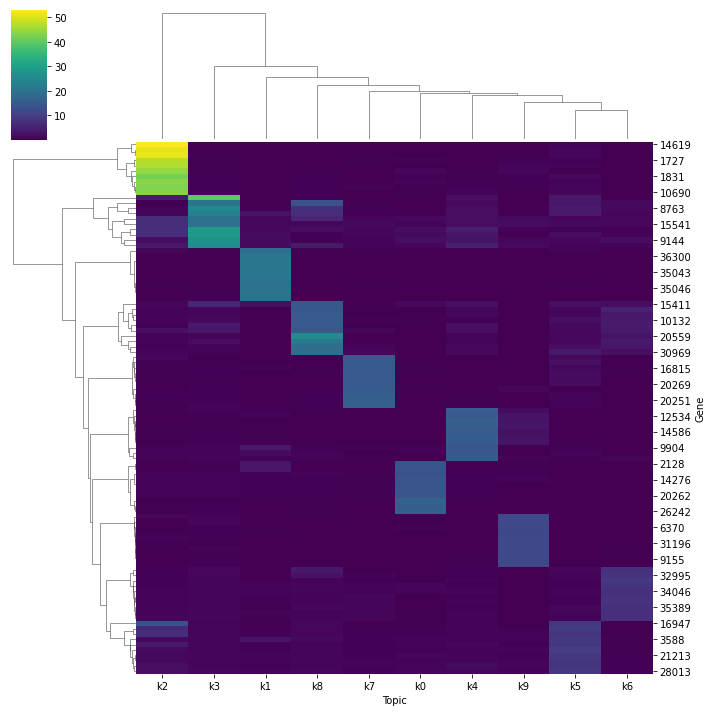

In [6]:
df_top = topics.get_topic_top_genes(df_beta.iloc[:,:],top_n=10)
df_top = df_top.pivot(index='Topic',columns='Gene',values='Proportion')
# df_top[df_top>20] = 20
sns.clustermap(df_top.T,cmap='viridis')

In [7]:
df_top

Gene,439,515,1362,1421,1722,1727,1736,1831,1955,1956,...,34992,35029,35043,35044,35045,35046,35389,35664,36300,36302
Topic,,,,,,,,,,,,,,,,,,,,,
k0,0.032912,0.081337,1.827572,0.771293,0.028525,0.477000,0.069597,0.408920,0.000988,0.007233,...,0.180596,0.189782,0.007856,0.011715,0.022800,0.015876,0.201934,0.310804,0.001842,0.006837
k1,0.256294,0.120708,1.135440,0.353897,0.027574,0.064927,0.068265,0.084941,0.092016,0.011406,...,0.274483,0.111918,20.911394,20.816591,20.415470,20.242575,0.148257,0.074737,21.068939,20.961008
k2,0.210188,0.329899,6.934105,1.966425,50.860176,47.190052,0.234913,41.849861,0.013388,0.030236,...,0.509824,0.240017,0.026529,0.038593,0.070141,0.061083,0.619622,0.110068,0.006718,0.022295
k3,0.369880,0.915741,28.742926,0.738957,0.068680,0.213406,0.357616,0.308802,0.950584,0.188376,...,0.760949,0.725499,0.043436,0.064428,0.258115,0.193607,0.895163,0.276261,0.014170,0.041335
k4,0.075020,0.388174,4.206608,1.514008,0.031601,0.133508,0.220661,0.229522,0.007390,0.017710,...,0.537860,0.497350,0.010712,0.015519,0.041169,0.036321,0.412745,0.162621,0.003102,0.010042
k5,0.051082,0.836708,0.240189,8.168617,0.857938,0.213783,0.695258,1.311949,0.014111,0.008727,...,0.290681,0.255647,0.006688,0.009993,0.022091,0.022130,0.886537,0.104608,0.001867,0.006597
k6,0.085111,7.394591,0.384475,0.224003,0.007172,0.026756,0.099279,0.041783,0.129833,0.209053,...,7.661144,8.406289,0.004930,0.007108,0.067404,0.164824,7.364568,0.103995,0.001637,0.004718
k7,0.060827,0.189071,0.996118,0.501388,0.126909,0.237599,15.485272,0.136106,0.004299,0.030696,...,0.723532,0.264250,0.008858,0.012755,0.036216,0.085306,0.829436,15.137230,0.002564,0.011975
k8,0.198407,3.447482,1.743156,0.686970,0.046040,0.142894,0.235855,0.283223,0.117427,0.056465,...,0.668538,0.490697,0.022774,0.033406,0.141051,0.099488,1.091609,0.146569,0.007230,0.022210


In [8]:
import umap
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

df_umap= pd.DataFrame()
df_umap['cell'] = dl.barcodes
# df_umap['topic_bulk'] = [x for x in df_theta.iloc[:,:].idxmax(axis=1)]

scaler = StandardScaler()
scaled = scaler.fit_transform(df_theta.to_numpy())
kmeans = KMeans(n_clusters=10, init='k-means++',random_state=0).fit(scaled)
df_umap['topic_bulk'] = kmeans.labels_

umap_2d = umap.UMAP(n_components=2, init='random', random_state=0,min_dist=0.4,metric='cosine')
proj_2d = umap_2d.fit(df_theta.iloc[:,:])
df_umap[['umap1','umap2']] = umap_2d.embedding_[:,[0,1]]
df_umap

# df_umap = pd.read_csv(sample_out+'_theta_umap.csv')
# df_umap.columns = ['cell','umap1','umap2']


,cell,topic_bulk,umap1,umap2
0,AAACATACAACCAC-1_3k_3k,4,14.338728,8.273410
1,AAACATTGAGCTAC-1_3k_3k,5,16.883301,3.660627
2,AAACATTGATCAGC-1_3k_3k,9,10.842478,9.798457
3,AAACCGTGCTTCCG-1_3k_3k,2,4.053499,6.768806
4,AAACCGTGTATGCG-1_3k_3k,0,8.838201,4.562924
...,...,...,...,...
7035,TTTGGTTTCGCTAGCG-1_4k_4k,8,10.178389,-1.094725
7036,TTTGTCACACTTAACG-1_4k_4k,1,-4.886355,4.225414
7037,TTTGTCACAGGTCCAC-1_4k_4k,3,-4.435318,8.565065
7038,TTTGTCAGTTAAGACA-1_4k_4k,7,2.737672,-7.113690


In [9]:
df_theta

,0,1,2,3,4,5,6,7,8,9
AAACATACAACCAC-1_3k_3k,0.569287,0.138489,1.640559,4.901428,0.432345,0.607560,0.676519,0.229794,2.469049,0.289163
AAACATTGAGCTAC-1_3k_3k,0.986613,0.616837,1.260733,4.554234,-0.049791,0.347496,0.511840,0.059305,1.856064,0.459992
AAACATTGATCAGC-1_3k_3k,0.588772,0.051243,0.664380,4.001326,0.367797,0.388047,0.631656,0.659981,2.270672,0.406289
AAACCGTGCTTCCG-1_3k_3k,0.727004,-0.048436,1.019191,2.396325,0.074184,-0.674058,-0.382817,-0.243875,0.597873,1.237839
AAACCGTGTATGCG-1_3k_3k,0.279413,-0.087579,1.545493,1.303358,0.509382,0.482762,0.079931,1.140628,0.798887,0.574888
...,...,...,...,...,...,...,...,...,...,...
TTTGGTTTCGCTAGCG-1_4k_4k,0.634971,0.002795,-0.106581,2.860720,-0.419135,-0.408807,0.211518,-0.121338,0.864525,1.150533
TTTGTCACACTTAACG-1_4k_4k,0.464239,0.125752,-0.574208,3.382362,-0.455745,0.393917,0.851194,0.844555,1.479315,0.307354
TTTGTCACAGGTCCAC-1_4k_4k,0.698766,0.224649,-0.020323,4.575604,-0.348908,0.484951,1.003600,0.540954,2.100914,0.236591
TTTGTCAGTTAAGACA-1_4k_4k,0.870275,0.756765,-0.535782,4.106853,-0.836051,0.036984,0.731589,0.117497,1.652833,0.247429


Text(0, 0.5, 'UMAP2')

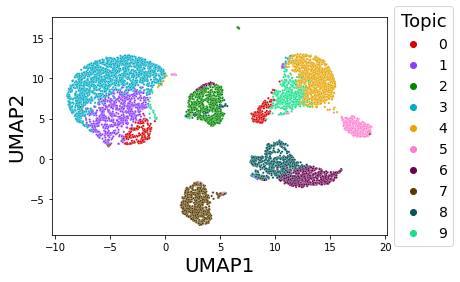

In [10]:
cp = sns.color_palette(cc.glasbey_dark, n_colors=len(df_umap['topic_bulk'].unique()))
p = sns.scatterplot(data=df_umap, x='umap1', y='umap2', hue='topic_bulk',s=5,palette=cp,legend=True)
plt.legend(title='Topic',title_fontsize=18, fontsize=14,loc='center left', bbox_to_anchor=(1, 0.5))
# p.axes.set_title("topics from bulkNMF",fontsize=30)
p.set_xlabel("UMAP1",fontsize=20)
p.set_ylabel("UMAP2",fontsize=20)

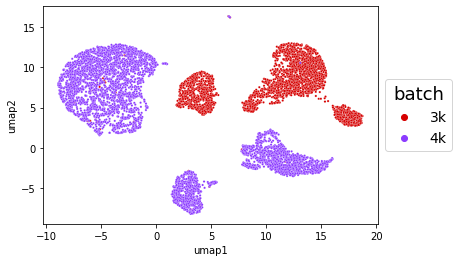

In [11]:
df_umap['batch'] = [x.split('_')[1]for x in df_umap['cell']]
cp = sns.color_palette(cc.glasbey_dark, n_colors=len(df_umap['batch'].unique()))
p = sns.scatterplot(data=df_umap, x='umap1', y='umap2', hue='batch',s=5,palette=cp,legend=True)
plt.legend(title='batch',title_fontsize=18, fontsize=14,loc='center left', bbox_to_anchor=(1, 0.5))

In [12]:
df_pl = pd.read_csv(dl.outpath+'_scanpy.csv.gz')
df_pl = df_pl[['cell','leiden']]
# df_pl = df_pl.loc[:,['Unnamed: 0','celltype_major']]
df_pl.columns = ['cell','cell_type']
df_pl['cell'] = [x.split('_')[0] for x in df_umap['cell']]
df_umap['cell'] = [x.split('_')[0] for x in df_umap['cell']]
df_umap = pd.merge(df_umap,df_pl[['cell','cell_type']],on='cell',how='left')
df_umap

,cell,topic_bulk,umap1,umap2,batch,cell_type
0,AAACATACAACCAC-1,4,14.338728,8.273410,3k,0
1,AAACATTGAGCTAC-1,5,16.883301,3.660627,3k,2
2,AAACATTGATCAGC-1,9,10.842478,9.798457,3k,1
3,AAACCGTGCTTCCG-1,2,4.053499,6.768806,3k,5
4,AAACCGTGTATGCG-1,0,8.838201,4.562924,3k,6
...,...,...,...,...,...,...
7035,TTTGGTTTCGCTAGCG-1,8,10.178389,-1.094725,4k,3
7036,TTTGTCACACTTAACG-1,1,-4.886355,4.225414,4k,6
7037,TTTGTCACAGGTCCAC-1,3,-4.435318,8.565065,4k,6
7038,TTTGTCAGTTAAGACA-1,7,2.737672,-7.113690,4k,2


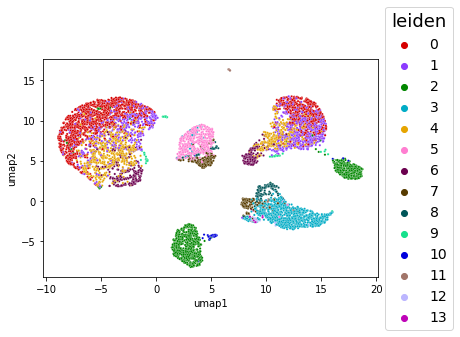

In [13]:
cp = sns.color_palette(cc.glasbey_dark, n_colors=len(df_umap['cell_type'].unique()))
p = sns.scatterplot(data=df_umap, x='umap1', y='umap2', hue='cell_type',s=5,palette=cp,legend=True)
plt.legend(title='leiden',title_fontsize=18, fontsize=14,loc='center left', bbox_to_anchor=(1, 0.5))

In [14]:
df_match = df_umap[['cell','cell_type','topic_bulk']]
df_match = df_match.groupby(['cell_type','topic_bulk']).count().reset_index()
df_match = df_match.pivot('cell_type','topic_bulk')
df_match = df_match.fillna(0)
df_match

cell                                                           \
topic_bulk      0      1      2       3      4      5      6      7      8   
cell_type                                                                    
0             0.0   35.0    0.0  1216.0  485.0    0.0    0.0    0.0    0.0   
1             1.0  122.0    1.0   348.0  499.0    0.0    0.0    0.0    0.0   
2             0.0    3.0    0.0    11.0    7.0  336.0    0.0  605.0    1.0   
3             0.0    6.0   11.0     3.0    0.0    0.0  555.0    0.0  309.0   
4            65.0  474.0    0.0    62.0   46.0    0.0    0.0    0.0    0.0   
5             0.0    0.0  440.0     0.0    1.0    1.0   28.0    0.0   14.0   
6           273.0   68.0    0.0     3.0    0.0    0.0    1.0    0.0    0.0   
7             0.0    0.0  156.0     2.0    0.0    0.0    0.0    0.0  132.0   
8             0.0    0.0    1.0     0.0    0.0    1.0    2.0    1.0  146.0   
9             1.0    0.0    0.0     1.0    4.0   12.0    1.0    0.0    0.0   
10            0.0    0.0    0.0     0.0    0.0   10.0    0.0   29.0    2.0   
11            0.0    0.0   16.0     0.0    0.0    0.0    5.0    0.0    7.0   
12            0.0    0.0    0.0     0.0    0.0    0.0    4.0    3.0   13.0   
13            0.0    1.0    0.0     0.0    0.0    0.0    4.0    0.0    9.0   

                   
topic_bulk      9  
cell_type          
0            17.0  
1           145.0  
2             2.0  
3             0.0  
4           230.0  
5             0.0  
6            25.0  
7             3.0  
8             0.0  
9            24.0  
10            0.0  
11            1.0  
12            0.0  
13            0.0

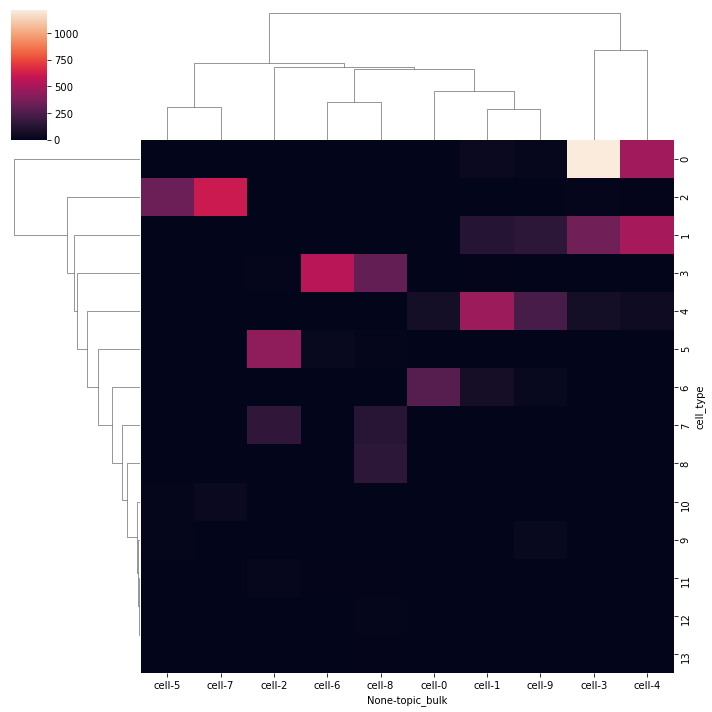

In [15]:
sns.clustermap(df_match)

In [16]:
from sklearn.metrics import normalized_mutual_info_score

normalized_mutual_info_score(df_umap['cell_type'].values,df_umap['topic_bulk'].values)

0.620103468169034